# CAICT 風機結冰預測 - Data Exploration 


** second key factor **
** 2017/08/09 **   

http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [1]:
from IPython.display import HTML
HTML('''<script>
presentation = 0;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

<a id='home'></a>
### Outline


In [60]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
import numpy as np
import lzma
import pickle
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as stats
import pylab
from pylab import *
import plastid
from collections import OrderedDict
from collections import OrderedDict
from PIL import Image

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from IPython.display import HTML

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn import preprocessing

import sklearn
import xgboost as xgb
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

# ‘all’|’last’|’last_expr’|’none’

In [3]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


def load_resample_data(mid, policy=1,  ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)

    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_expo_data(mid=15,policy=0):
    non_data_cols = ['label','time','group','timestamp','event']
    data_raw, data_X, _, _ = load_resample_data(mid=mid,policy=policy)
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled


In [80]:
def checkPath(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc: 
            if exc.errno != errno.EEXIST:
                raise

In [118]:
def getSSE(data_pass_x, data_pass_y, windowsize):
    model = LinearRegression()
    model.fit(data_pass_x,data_pass_y)
    pred = model.predict(data_pass_x)
    mse = mean_squared_error(data_pass_y, pred)
    sse = mse * windowsize
    return sse


<a id='input'></a>
** Input Data **  
data resample policy
- 15號風機
- remove 無效數據
- 沒有做resampling

In [85]:
_, data_scaled_M15 = load_expo_data(mid=15,policy=0)
#_, dat_scaled_M15 = load_expo_data(mid=15,policy=4)

#dat_scaled_M15_Complete, _ = add_feature_windspeed(dat_scaled_M15_Complete)
#dat_scaled_M15, _ = add_feature_windspeed(dat_scaled_M15)


load file: data/resample_data_p4_15.csv


** Exploration **
- Training Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0 
  - pass data only
- Prediction Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0
- model
  - all x
  - xgboost 
  


In [74]:
evt = 3
dava_evt = data_scaled_M15[data_scaled_M15['event']==evt]
data_pass= dava_evt[dava_evt['label']==0]
data_fail= dava_evt[dava_evt['label']==1]
data_unknown= dava_evt[dava_evt['label']==2]


In [75]:
cols = ['wind_speed', 'wind_direction',
       'wind_direction_mean', 'yaw_position', 'yaw_speed', 'pitch1_angle',
       'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed',
       'pitch3_speed', 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp',
       'acc_x', 'acc_y', 'environment_tmp', 'int_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC',
       'pitch3_ng5_DC']

** PASS DATA **

In [173]:
data_pass_y = data_pass['power']
data_pass_x = data_pass[cols]
window_sizes = range(10,110,10)
sse_dict=OrderedDict()
for window_size in window_sizes:
    sse_list=[]
    for idx in range(0,data_pass.shape[0],window_size):
        start_idx = idx-window_size
        end_idx = idx
        if start_idx<0:
            sse_list.append(0)
            continue
        sse = getSSE(data_pass_x[start_idx:end_idx],data_pass_y[start_idx:end_idx],window_size)
        sse_list.append(sse)
    sse_dict[window_size]=np.sum(sse_list)

    

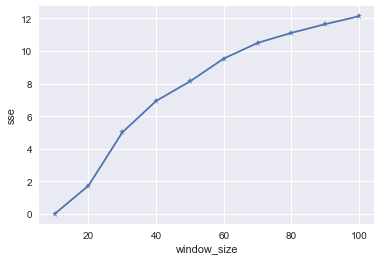

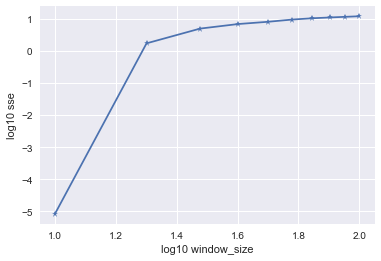

In [240]:
path='case_management/img/all/rolling_sse_pass/'
checkPath(path)
n=0
x = list(sse_dict.keys())
y = list(sse_dict.values())
plt.plot(x[n:],y[n:], marker='*')
plt.xlabel('window_size')
plt.ylabel('sse')
imagename='{p}{f}_{d}.jpg'.format(p=path, f='pass',d=1)
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()


plt.plot(np.log10(x)[n:], np.log10(y)[n:], marker='*')
plt.xlabel('log10 window_size')
plt.ylabel('log10 sse')
imagename='{p}{f}_{d}.jpg'.format(p=path, f='pass',d=2)
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()

** ALL DATA **

In [274]:
data_pass_y = dava_evt['power']
data_pass_x = dava_evt[cols]
window_sizes = range(10,110,10)
sse_dict2=OrderedDict()
for window_size in window_sizes:
    sse_list=[]
    for idx in range(0,dava_evt.shape[0],window_size):
        start_idx = idx-window_size
        end_idx = idx
        if start_idx<0:
            sse_list.append(0)
            continue
        sse = getSSE(data_pass_x[start_idx:end_idx],data_pass_y[start_idx:end_idx],window_size)
        sse_list.append(sse)
    sse_dict2[window_size]=np.sum(sse_list)

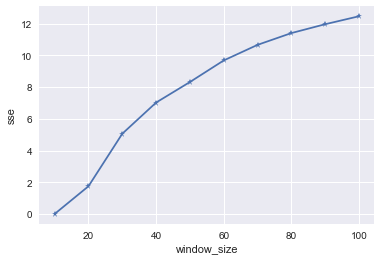

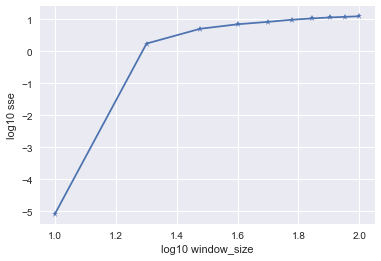

In [275]:
###### path='case_management/img/all/rolling_sse_all/'
checkPath(path)
x = list(sse_dict2.keys())
y = list(sse_dict2.values())
plt.plot(x,y, marker='*')
plt.xlabel('window_size')
plt.ylabel('sse')
imagename='{p}{f}_{d}.jpg'.format(p=path, f='all',d=1)
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()

plt.plot(np.log10(x), np.log10(y), marker='*')
plt.xlabel('log10 window_size')
plt.ylabel('log10 sse')
imagename='{p}{f}_{d}.jpg'.format(p=path, f='all',d=2)
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()

In [276]:
window_sizes = range(20,50,10)

ssetmp_list=[]
alpha_list=[]
r2_list=[]
for i in range(0,dava_evt.shape[0],120):
    start_idx = i-120
    end_idx = i
    if start_idx <0:
        continue
    data = dava_evt[start_idx:end_idx]
    data_y = data['power']
    data_x = data[cols]
    sse_dict2=OrderedDict()
    for window_size in window_sizes:
        sse_list=[]
        for idx in range(0,data.shape[0],window_size):
            start_idx = idx-window_size
            end_idx = idx
            if start_idx<0:
                sse_list.append(0)
                continue
            sse = getSSE(data_x[start_idx:end_idx],data_y[start_idx:end_idx],window_size)
            sse_list.append(sse)
        sse_dict2[window_size]=np.sum(sse_list)
    ssetmp_list.append(sse_dict2)
    alpha, r2 = getAlpha(sse_dict2)
    alpha_list.append(alpha)
    r2_list.append(r2)
    

355

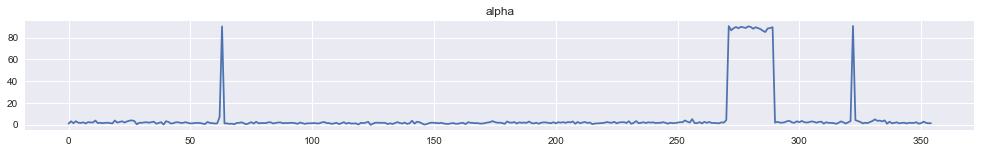

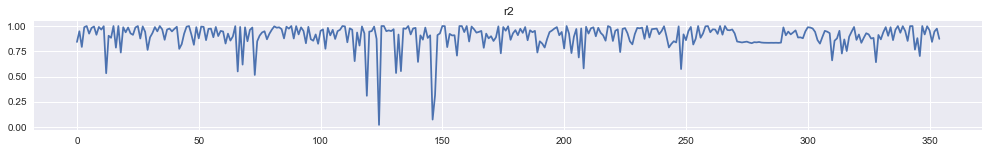

In [277]:
len(alpha_list)
fig = plt.figure(figsize=[17,2])
plt.plot(alpha_list)
#plt.ylim((0,7))
plt.title('alpha')
fig = plt.figure(figsize=[17,2])
plt.plot(r2_list)
plt.title('r2')

In [251]:
summarydf=pd.DataFrame({'alpha':alpha_list, 'r2':r2_list,'sse_dict':ssetmp_list})

In [264]:
#summarydf[summarydf['alpha']>60]

In [233]:

def getAlpha(sse_dict):
    x = np.array(list(sse_dict.keys()))
    y = np.array(list(sse_dict.values()))
    x = np.log10(x)
    y = np.log10(y)
    model = LinearRegression()
    model.fit(x.reshape(len(y),-1),y)
    pred = model.predict(x.reshape(len(y),-1))
    r2_p = sklearn.metrics.r2_score(y,pred)
    return model.coef_[0], r2_p


In [262]:
def fractalplot(sse_dict):
    n=0
    x = list(sse_dict.keys())
    y = list(sse_dict.values())
    #plt.plot(x[n:],y[n:], marker='*')
    #plt.xlabel('window_size')
    #plt.ylabel('sse')
    #imagename='{p}{f}_{d}.jpg'.format(p=path, f='pass',d=1)
    #plt.savefig(imagename,bbox_inches='tight', dpi=200)
    #plt.show()

    plt.plot(np.log10(x)[n:], np.log10(y)[n:], marker='*')
    plt.xlabel('log10 window_size')
    plt.ylabel('log10 sse')
    #imagename='{p}{f}_{d}.jpg'.format(p=path, f='pass',d=2)
    #plt.savefig(imagename,bbox_inches='tight', dpi=200)
    plt.show()

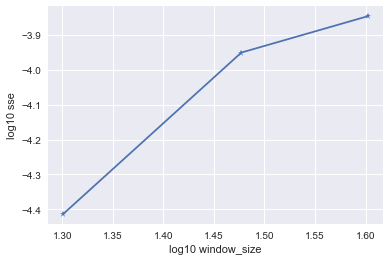

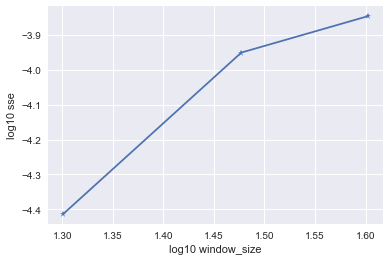

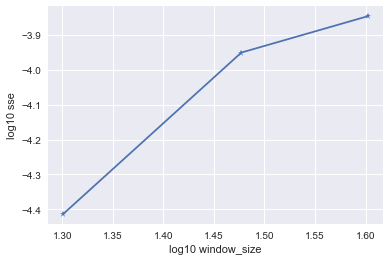

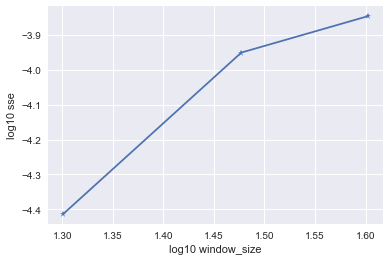

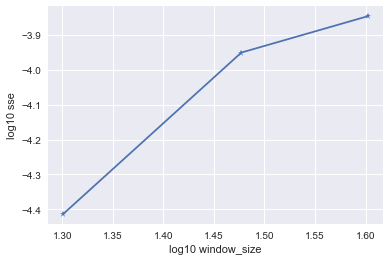

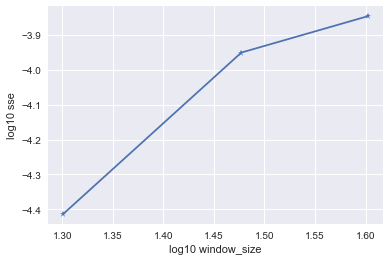

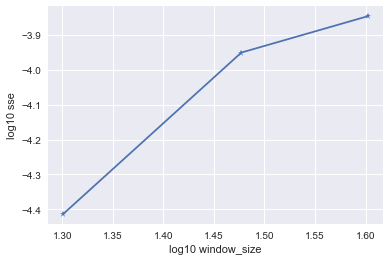

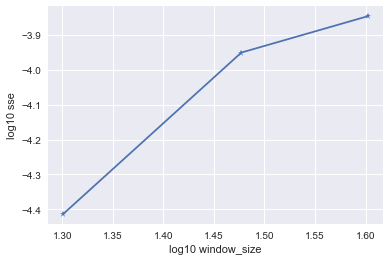

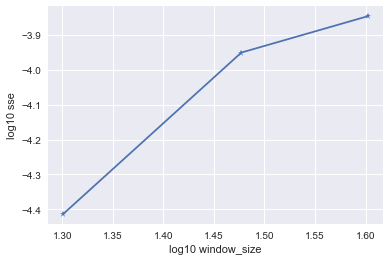

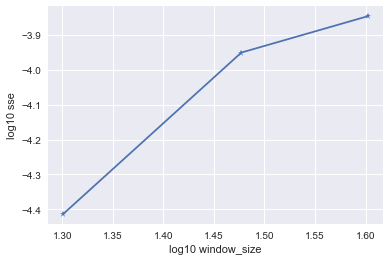

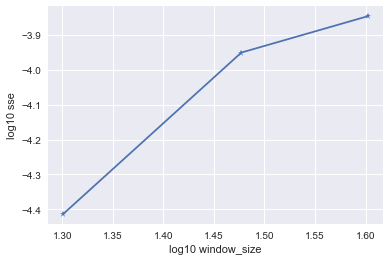

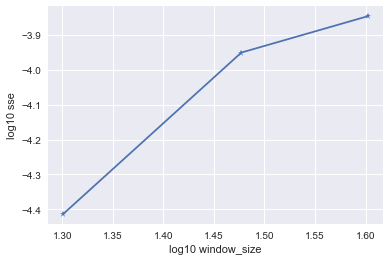

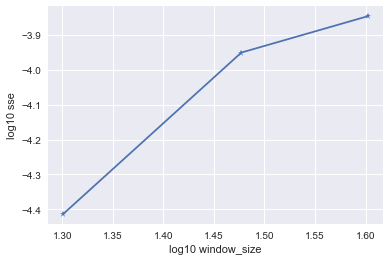

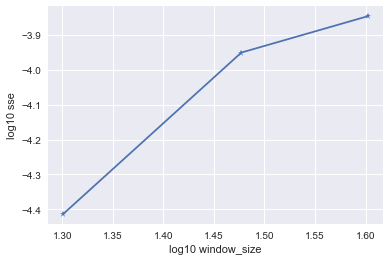

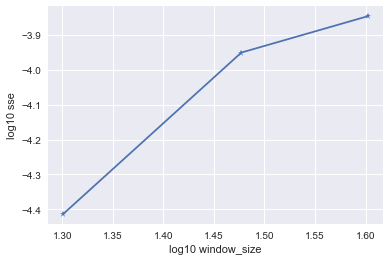

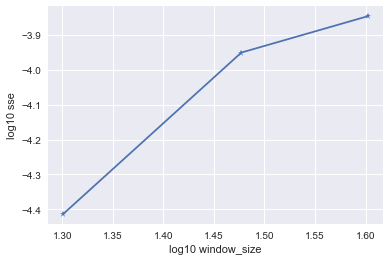

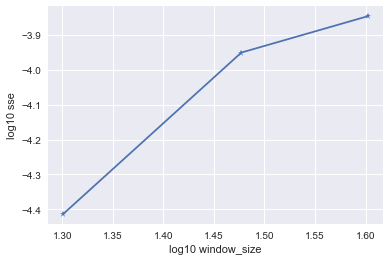

In [250]:
for i in range(0,335,20):
    fractalplot(ssetmp_list[20])

** 3. by event check the bias **

![](img/named_colors.png)